Nama: Riski Abdi Rahmawan

Kelas: TI-3E

Absen: 25
# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

# Preparation

In [132]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Kode di atas mengimpor pustaka yang diperlukan untuk proyek pembelajaran mesin. Kode ini memuat pustaka populer seperti NumPy dan Pandas untuk perhitungan numerik dan manipulasi data. Selain itu, kode ini mengimpor beberapa modul dari scikit-learn, termasuk kumpulan data untuk memuat kumpulan data orang LFW, model_selection untuk membagi data, svm untuk klasifikasi Support Vector Machine, dekomposisi untuk Principal Component Analysis, praproses untuk menstandardisasi data, dan metrik untuk mengevaluasi kinerja model. Terakhir, kode ini mengimpor Matplotlib dan Seaborn untuk visualisasi data.

# Load Data

In [133]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=10, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 158
Data dimension: (4324, 62, 47, 3)
Images flatten dimension: (4324, 8742)


Kode tersebut bertujuan untuk memuat dataset gambar wajah menggunakan fungsi `fetch_lfw_people` dari Scikit-learn, di mana hanya wajah-wajah dengan minimal 10 gambar per orang yang disertakan dan gambar diambil dalam format berwarna. Setelah dataset dimuat, kode ini mencetak beberapa informasi penting. Pertama, jumlah total label atau individu unik dalam dataset dihitung menggunakan atribut `faces.target_names`. Selanjutnya, dimensi asli dari gambar wajah dalam dataset dicetak menggunakan atribut `faces.images.shape`, yang merepresentasikan gambar dalam format matriks 2D dengan kanal warna. Terakhir, gambar-gambar tersebut diubah menjadi bentuk vektor 1D (dengan mengubah matriks gambar menjadi satu baris pixel) dan dimensi hasil vektor ini ditampilkan menggunakan `faces.data.shape`. Tujuan dari kode ini adalah untuk memeriksa ukuran dan struktur dataset sebelum melakukan pemrosesan lebih lanjut.

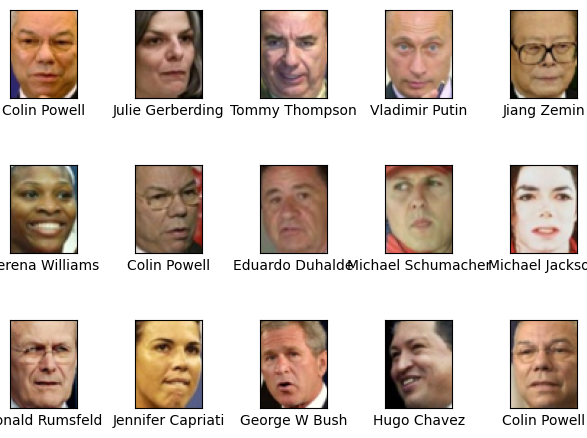

In [134]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

Kode ini menampilkan 15 gambar wajah acak dari dataset dalam grid 3x5. Indeks acak dipilih menggunakan `np.random.randint`, dan gambar-gambar tersebut ditampilkan dengan skema warna grayscale (`cmap='bone'`). Setiap subplot menampilkan gambar tanpa sumbu dan diberi label nama individu yang sesuai. Tata letak diatur rapat menggunakan `tight_layout()` untuk memastikan gambar tidak saling tumpang tindih.

# Preprocessing

In [135]:
'''
    Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa,

    1. Standardisasi nilai fitur ataupun label
    2. Penyesuaian ukuran gambar
    3. Perubahan colorspace gambar
    4. dsb
'''
# Preprocessing
X = faces.data
y = faces.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
n_components = 150  # You can adjust this
pca = PCA(n_components=n_components, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Kode ini membagi dataset wajah menjadi data latih dan uji dengan rasio 70:30 menggunakan `train_test_split`. Selanjutnya, data distandarisasi menggunakan `StandardScaler` untuk memiliki mean 0 dan standar deviasi 1. Setelah itu, dilakukan reduksi dimensi menggunakan PCA dengan 150 komponen utama agar data lebih ringkas dan siap digunakan dalam model pembelajaran mesin.

# Features Extraction

In [136]:
'''
    Pada bagian ini, lakukan proses ekstraksi fitur yang diminta, yaitu histogram tiap channel.
    Terdapat banyak cara untuk melakukan ekstraksi fitur histrogram.

    Hints:
        Salah satu cara untuk melakukan ekstraksi fitur histrogram adalah,
        Anda dapat menggunakan fungsi np.histrogram dari library numpy
'''

# Function Extract Histogram Features For Each Channel
def generate_hist(data, bins_num=5):
    hist_data = []

    for i in data:
        h_red = np.histogram(i[0][..., 0].ravel(), bins=bins_num)[0]
        h_green = np.histogram(i[1][..., 1].ravel(), bins=bins_num)[0]
        h_blue = np.histogram(i[2][..., 2].ravel(), bins=bins_num)[0]

        h_concat = np.concatenate((h_red, h_green, h_blue), axis=0) # Concat in row basis

        hist_data.append(h_concat)

    return np.array(hist_data)

Fungsi `generate_hist` mengekstrak fitur histogram dari setiap saluran warna (merah, hijau, biru) dalam dataset gambar. Untuk setiap gambar, histogram dihitung untuk masing-masing saluran menggunakan 5 bin (atau sesuai jumlah bin yang ditentukan). Histogram dari ketiga saluran digabungkan dan disimpan dalam array, yang kemudian dikembalikan sebagai output.

In [137]:
# Extract histogram feature
hist_features = generate_hist(faces.images, bins_num=50)
hist_features.shape

(4324, 150)

Kode ini mengekstrak fitur histogram dari gambar dalam dataset wajah menggunakan fungsi `generate_hist` dengan 50 bin untuk setiap saluran warna. Hasilnya disimpan dalam `hist_features`, dan bentuk (dimensi) dari fitur yang dihasilkan ditampilkan dengan `hist_features.shape`.

# Build Model

In [138]:
'''
    Pada bagian ini lakukan proses pembuatan model,

    1. Pembuatan data training dan data testing
    2. Pembuatan objek model
    3. Proses fitting model
'''

# # Build a Model
# Train SVM
svm = SVC()
svm.fit(X_train_pca, y_train)

SVC()

Kode ini membangun dan melatih model Support Vector Machine (SVM) untuk klasifikasi. Pertama, objek SVM dibuat dengan `SVC()`, yang merupakan kelas dari library Scikit-learn. Kemudian, model dilatih menggunakan data latih yang telah direduksi dimensinya dengan PCA (`X_train_pca`) dan label target yang sesuai (`y_train`) dengan memanggil metode `fit`. Model SVM ini akan belajar untuk mengklasifikasikan gambar wajah berdasarkan fitur yang telah disiapkan.

# Evaluation

In [139]:
'''
    Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
    dengan menggunakan metric akurasi dan juga classfication report

    Hints:
        Anda dapat menggunakan referensi Jobseet 4 Percobaan 5
'''

# Predict on both train and test sets
y_train_pred = svm.predict(X_train_pca)
y_test_pred = svm.predict(X_test_pca)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8225
Testing Accuracy: 0.3351


Kode ini melakukan prediksi pada data latih dan uji menggunakan model SVM yang telah dilatih. Dengan memanggil metode `predict`, label yang diprediksi untuk data latih (`y_train_pred`) dan data uji (`y_test_pred`) dihitung. Selanjutnya, akurasi untuk kedua set data dihitung menggunakan `accuracy_score`, membandingkan label sebenarnya dengan label yang diprediksi. Akurasi pelatihan dan pengujian kemudian dicetak dengan format empat desimal.

In [140]:
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=faces.target_names))


Classification Report (Test Set):
                           precision    recall  f1-score   support

             Abdullah Gul       0.00      0.00      0.00         6
             Adrien Brody       0.00      0.00      0.00         2
         Alejandro Toledo       0.33      0.14      0.20         7
             Alvaro Uribe       1.00      0.36      0.53        11
          Amelie Mauresmo       0.00      0.00      0.00         7
             Andre Agassi       1.00      0.25      0.40         4
             Andy Roddick       0.00      0.00      0.00         5
           Angelina Jolie       0.00      0.00      0.00         3
              Ann Veneman       0.00      0.00      0.00         3
          Anna Kournikova       0.00      0.00      0.00         3
            Ari Fleischer       0.00      0.00      0.00         5
             Ariel Sharon       0.60      0.60      0.60        20
    Arnold Schwarzenegger       0.00      0.00      0.00        21
     Atal Bihari Vajpayee 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Kode ini mencetak laporan klasifikasi untuk set data uji, yang memberikan informasi detail tentang kinerja model SVM. Dengan menggunakan fungsi `classification_report`, laporan ini menyajikan metrik evaluasi seperti presisi, recall, dan F1-score untuk setiap kelas, berdasarkan label sebenarnya (`y_test`) dan label yang diprediksi (`y_test_pred`). Nama target dari dataset wajah juga disertakan melalui parameter `target_names`, sehingga hasil laporan lebih mudah dipahami.

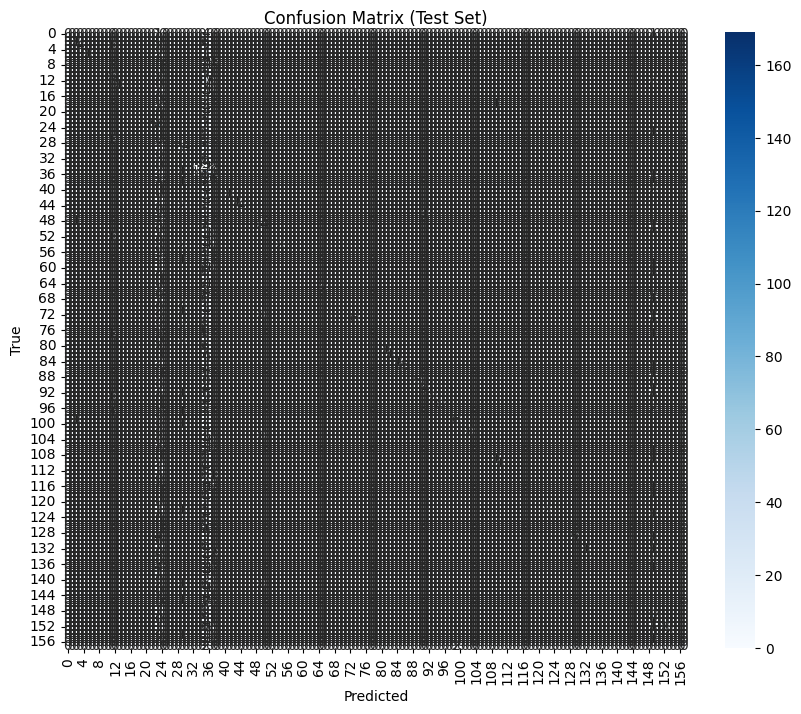

In [141]:
# # Eval Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

Kode ini menghasilkan dan menampilkan matriks kebingungan untuk set data uji menggunakan `confusion_matrix`. Matriks ini menunjukkan jumlah prediksi yang benar dan salah untuk setiap kelas. Dengan menggunakan Seaborn, matriks ditampilkan sebagai heatmap dengan anotasi jumlah prediksi di dalam setiap sel, diwarnai dengan palet warna biru. Label sumbu X dan Y masing-masing menunjukkan kelas yang diprediksi dan kelas sebenarnya, dan judul grafik menandakan bahwa ini adalah matriks kebingungan untuk set uji. Setelah semua pengaturan selesai, heatmap ditampilkan dengan `plt.show()`.

## Challenge 1

In [112]:
def generate_hist_manual(data, bins_num=5):
    hist_data = []

    for i in data:
        # Hitung rentang nilai piksel pada setiap kanal
        min_val = np.min(i)
        max_val = np.max(i)

        # Buat array untuk menyimpan distribusi frekuensi
        h_red = np.zeros(bins_num)
        h_green = np.zeros(bins_num)
        h_blue = np.zeros(bins_num)

        # Hitung distribusi frekuensi nilai-nilai piksel pada setiap kanal
        for j in range(3):
            if j == 0:
                kanal = i[0][..., 0].ravel()
            elif j == 1:
                kanal = i[1][..., 1].ravel()
            else:
                kanal = i[2][..., 2].ravel()

            bin_width = (max_val - min_val) / bins_num
            for k in kanal:
                bin_idx = int((k - min_val) / bin_width)
                if bin_idx == bins_num:
                    bin_idx -= 1
                if j == 0:
                    h_red[bin_idx] += 1
                elif j == 1:
                    h_green[bin_idx] += 1
                else:
                    h_blue[bin_idx] += 1

        # Normalisasi distribusi frekuensi
        h_red = h_red / len(i[0][..., 0].ravel())
        h_green = h_green / len(i[1][..., 1].ravel())
        h_blue = h_blue / len(i[2][..., 2].ravel())

        # Gabungkan distribusi frekuensi pada setiap kanal
        h_concat = np.concatenate((h_red, h_green, h_blue), axis=0)

        hist_data.append(h_concat)

    return np.array(hist_data)

    # Extract histogram feature
hist_features = generate_hist(faces.images, bins_num=50)
hist_features.shape

(4324, 150)

In [129]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_pca)

# Calculate accuracy for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy (Random Forest): {accuracy_rf:.2f}')

# Print classification report for Random Forest
print('Classification Report (Random Forest):')
print(classification_report(y_test, y_pred_rf, target_names=faces.target_names))


Accuracy (Random Forest): 0.23
Classification Report (Random Forest):
                           precision    recall  f1-score   support

             Abdullah Gul       1.00      0.17      0.29         6
             Adrien Brody       0.00      0.00      0.00         2
         Alejandro Toledo       0.20      0.14      0.17         7
             Alvaro Uribe       0.00      0.00      0.00        11
          Amelie Mauresmo       0.00      0.00      0.00         7
             Andre Agassi       0.00      0.00      0.00         4
             Andy Roddick       0.00      0.00      0.00         5
           Angelina Jolie       0.00      0.00      0.00         3
              Ann Veneman       0.00      0.00      0.00         3
          Anna Kournikova       0.00      0.00      0.00         3
            Ari Fleischer       0.00      0.00      0.00         5
             Ariel Sharon       0.33      0.15      0.21        20
    Arnold Schwarzenegger       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
